# ExpW

label.lst： each line indicates an image as follows:
image_name face_id_in_image face_box_top face_box_left face_box_right face_box_bottom face_box_confidence expression_labela

for expression label：
- "0" : "angry"
- "1" : "disgust"
- "2" : "fear"
- "3" : "happy"
- "4" : "sad"
- "5" : "surprise"
- "6" : "neutral"

Mounting google drive content

In [8]:
from google.colab import auth
auth.authenticate_user()

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [10]:
import os
import cv2
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Running on device: cpu


## Paths

In [11]:
DATASET_PATH = "/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/"
LABELS_FOLDER = "labels/"
IMAGES_FOLDER = "images/"

## Functions

In [12]:
def series_as_type(series, type):
    return series.astype(type)

In [13]:
def plot_image(img):
  plt.figure(figsize=(20,10))
  plt.imshow(img)
  plt.axis('off')

In [14]:
def draw_face_rectangle(face, img):
    thickness = 4
    for (x1, y1, x2, y2) in face:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), thickness)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [15]:
def make_box(row):
    return [[row['face_box_top'], row['face_box_left'], row['face_box_bottom'], row['face_box_right']]]

In [16]:
def draw_image_and_face_rectangle(filename, boxes, verbose=False):
    if verbose:
        print(f"image name {filename}")

    pixels = plt.imread(filename)
    print(pixels.shape)
    img_mtcnn = cv2.imread(filename)

    faces_detected = draw_face_rectangle(boxes, img_mtcnn)
    plot_image(faces_detected)

## Labels
First of all, we will load labels for each file

In [17]:
LABEL_FILE = "label.lst"

labels = []
with open(DATASET_PATH + LABELS_FOLDER + LABEL_FILE) as f:
    lines = f.readlines()
    labels = [line.replace('\n', '').split(' ') for line in lines]

assert len(labels) == len(lines)

In [18]:
columns = ['file_name', 'face_id_in_image', 'face_box_top', 'face_box_left', 'face_box_right', 'face_box_bottom', 'face_box_confidence', 'expression_label']

df = pd.DataFrame(labels, columns=columns)

df.drop_duplicates(subset=['file_name', 'face_id_in_image'], inplace=True)

In [19]:
df.sample(5)

,file_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label
38298,crying_programmer_264.jpg,0,38,47,161,152,91.7476,3
80022,awe_expression_624.jpg,0,77,115,230,192,84.6851,6
46404,amazed_american_283.jpg,0,32,48,241,225,68.1438,5
45154,heartbroken_soldier_509.jpg,1,457,786,882,553,48.9296,6
29015,distressed_actor_147.jpg,1,173,906,1066,333,33.7847,1


In [20]:
new_types = {
    'face_box_top': 'int32',
    'face_box_left': 'int32',
    'face_box_right': 'int32',
    'face_box_bottom': 'int32',
    'face_box_confidence': 'float32',
    'expression_label': 'int32'
}

for key, new_type in new_types.items():
    df[key] = series_as_type(df[key], new_type)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88600 entries, 0 to 91792
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file_name            88600 non-null  object 
 1   face_id_in_image     88600 non-null  object 
 2   face_box_top         88600 non-null  int32  
 3   face_box_left        88600 non-null  int32  
 4   face_box_right       88600 non-null  int32  
 5   face_box_bottom      88600 non-null  int32  
 6   face_box_confidence  88600 non-null  float32
 7   expression_label     88600 non-null  int32  
dtypes: float32(1), int32(5), object(2)
memory usage: 4.1+ MB


In [21]:
f"There are {len(df)} tagged faces in {len(df['file_name'].unique())} images"

'There are 88600 tagged faces in 68096 images'

## Images with multiple faces and images with single faces

Now we will see the how many images have multiple faces

In [22]:
df_multiple_faces = df.loc[df.duplicated(subset='file_name', keep=False)]
df_multiple_faces.shape

(32513, 8)

In [23]:
multiple_faces_images = df_multiple_faces['file_name'].unique()
images = df['file_name'].unique()

print(f"There are {len(multiple_faces_images)} images with multiple faces. This is {(len(multiple_faces_images)/len(images) * 100):.2f}%")
print(f"Therefore, there are {len(images) - len(df_multiple_faces['file_name'].unique())} images with only one face. This is {((len(images) - len(df_multiple_faces['file_name'].unique())) / len(images) * 100):.2f}%")

There are 12009 images with multiple faces. This is 17.64%
Therefore, there are 56087 images with only one face. This is 82.36%


In [24]:
df_stats = pd.DataFrame()
grouped = df_multiple_faces.groupby('file_name')
for group, frame in grouped:
    stats = {
        'group': group,
        'number_of_faces': len(frame)
    }
    df_stats = pd.concat([df_stats, pd.DataFrame([stats])], ignore_index=True)
df_stats.shape

(12009, 2)

In [25]:
# this plot could never be drawn, probably due to the amount of elements
# df_stats.plot(kind='scatter', x='group', y='number_of_faces')

With this information, we will tag multiple faces files in a new 'multiple_faces' field

In [26]:
df['multiple_faces'] = df['file_name'].apply(lambda x: x in multiple_faces_images)
df['multiple_faces'].value_counts()

False    56087
True     32513
Name: multiple_faces, dtype: int64

## Expressions as names
Now we will transform numeric expressions into their actual meaning for plot purposes

In [27]:
expressions = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}

In [28]:
df['expression_name'] = df['expression_label']
df['expression_name'] = df['expression_name'].replace(expressions)
df['expression_name'].value_counts()

neutral     33927
happy       28893
sad         10429
surprise     6880
disgust      3805
angry        3602
fear         1064
Name: expression_name, dtype: int64

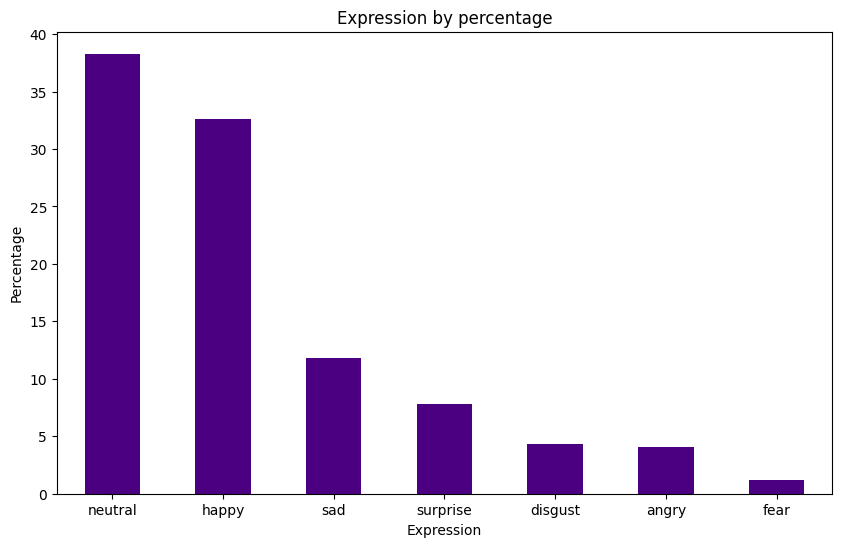

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))

df['expression_name'].value_counts(normalize=True).map(lambda x: x * 100).\
    plot(kind='bar', ax=ax, title='Expression by percentage', color='indigo',
         xlabel='Expression', ylabel='Percentage', rot=0)

plt.show()

## Updated df

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88600 entries, 0 to 91792
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file_name            88600 non-null  object 
 1   face_id_in_image     88600 non-null  object 
 2   face_box_top         88600 non-null  int32  
 3   face_box_left        88600 non-null  int32  
 4   face_box_right       88600 non-null  int32  
 5   face_box_bottom      88600 non-null  int32  
 6   face_box_confidence  88600 non-null  float32
 7   expression_label     88600 non-null  int32  
 8   multiple_faces       88600 non-null  bool   
 9   expression_name      88600 non-null  object 
dtypes: bool(1), float32(1), int32(5), object(3)
memory usage: 4.8+ MB


In [31]:
NEW_LABEL_FILE = 'labels_v1.csv'

In [32]:
# updated_df_to_save = df.drop(columns=['box'])
# updated_df_to_save.to_csv(DATASET_PATH + LABELS_FOLDER + NEW_LABEL_FILE, sep=',', encoding='utf-8', index=False)

## Check boxes and confidence

In [33]:
df[['face_box_confidence']].describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])

,face_box_confidence
count,88600.000000
mean,49.780151
std,25.211403
min,0.010154
5%,10.006875
25%,30.057775
50%,49.191750
75%,68.399977
95%,91.842630
max,142.412994


<Axes: >

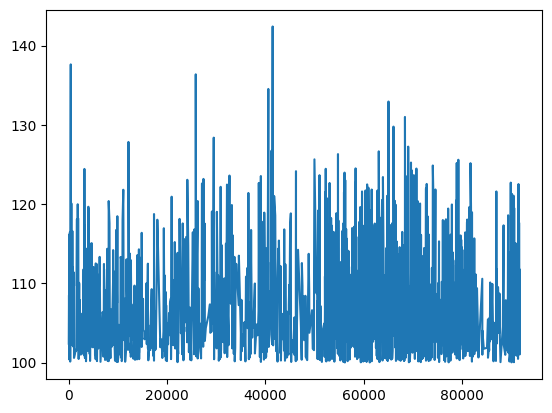

In [34]:
# We verify face_box_confidence over one hundred (thought this should have been a percentage...)
df.loc[df['face_box_confidence'] > 100]['face_box_confidence'].plot(kind='line')

In [35]:
df['box'] = df.apply(lambda row: np.array(make_box(row)), axis=1)

Let's look at some of the images and their bounding boxes that have more than 90% of confidence

In [36]:
# sample = df.loc[(df['face_box_confidence'] > 100) & (df['multiple_faces'] == True), :].sample(2)
# sample.head()

In [37]:
# for index, row in sample.iterrows():
#     filename = DATASET_PATH + IMAGES_FOLDER + row['file_name']
#     draw_image_and_face_rectangle(filename, row['box'], verbose=True)

In [38]:
# example_path = '/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/awe_father_901.jpg'
# row_example = df[df['file_name'] == 'awe_father_901.jpg']

# example_path_2 = '/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/fierce_yang_743.jpg'
# row_example_2 = df[df['file_name'] == 'fierce_yang_743.jpg']

In [39]:
# row_example

In [40]:
# row_example.iloc[0]

In [41]:
# draw_image_and_face_rectangle(example_path, row_example.iloc[0]['box'], verbose=True)

## Resize image using Pil

In [42]:
sample = df.sample(10)
sample.head()

,file_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_confidence,expression_label,multiple_faces,expression_name,box
9108,fighting_family_615.jpg,3,79,354,401,126,27.995800,6,False,neutral,"[[79, 354, 126, 401]]"
12647,hostile_manager_411.jpg,0,93,380,460,173,59.956799,6,False,neutral,"[[93, 380, 173, 460]]"
89997,amazed_boy_130.jpg,0,62,136,204,130,74.154701,5,False,surprise,"[[62, 136, 130, 204]]"
66627,awe_european_611.jpg,0,108,305,353,156,18.274200,3,True,happy,"[[108, 305, 156, 353]]"
1153,angry_face_351.jpg,0,75,189,642,528,41.530300,0,False,angry,"[[75, 189, 528, 642]]"


In [71]:
from PIL import Image, ImageDraw
import IPython.display as display

THICKNESS = 4

def draw_face_rectangle(face, img):
    thickness = 4
    draw = ImageDraw.Draw(img)
    draw.rectangle([(0, 0), (100, 100)], width=THICKNESS)
    return draw

def draw_image_and_face_rectangle(filename, boxes, verbose=False):
    if verbose:
        print(f"image name {filename}")

    pixels = plt.imread(filename)
    print(pixels.shape)
    img_mtcnn = Image.open(filename).convert('L')
    img_mtcnn.thumbnail((320,240), Image.LANCZOS)
    print(img_mtcnn.size)

    draw = draw_face_rectangle(boxes, img_mtcnn)
    display.display(img_mtcnn)

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/fighting_family_615.jpg
(466, 700, 3)
(320, 213)


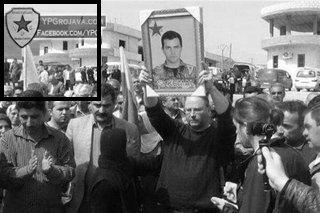

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/hostile_manager_411.jpg
(434, 620, 3)
(320, 224)


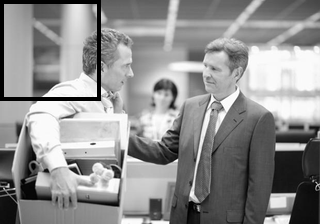

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/amazed_boy_130.jpg
(470, 301, 3)
(154, 240)


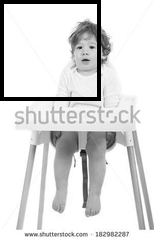

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/awe_european_611.jpg
(345, 478, 3)
(320, 231)


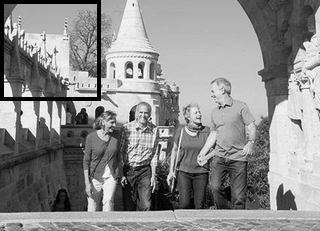

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/angry_face_351.jpg
(651, 900, 3)
(320, 231)


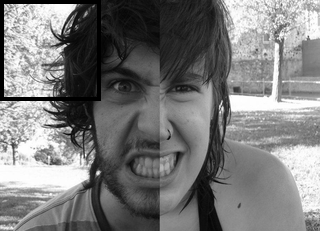

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/boring_girl_418.jpg
(435, 570, 3)
(314, 240)


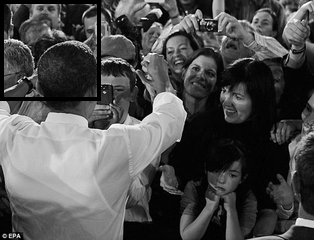

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/annoyed_chinese_363.jpg
(899, 1600, 3)
(320, 180)


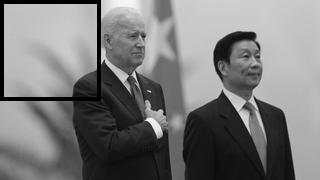

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/crying_president_484.jpg
(678, 1024, 3)
(320, 212)


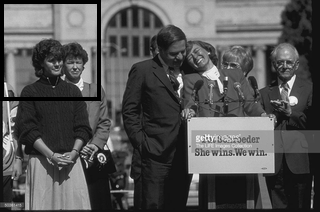

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/fighting_man_256.jpg
(354, 500, 3)
(320, 227)


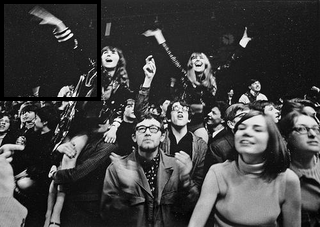

image name /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/amazed_student_93.jpg
(110, 73, 3)
(73, 110)


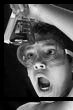

In [72]:
example_path = '/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/ExpW/images/'

for index, row in sample.iterrows():
    draw_image_and_face_rectangle(example_path + row['file_name'], row['box'], verbose=True)